In [1]:
import os
import json
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

W0622 10:26:15.347722 140358802494848 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
PATH="../input/iwildcam-2019-fgvc6/"
PATH

'../input/iwildcam-2019-fgvc6/'

## 1. Loading the dataset

In [3]:
path_to_zip = "../input/iwildcam-2019-fgvc6/train_images.zip"
directory_to_extract="../output/kaggle/working/train_images"

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract)

In [4]:
train_image_files = list(os.listdir(os.path.join(directory_to_extract)))
print("Number of image files: train:{}".format(len(train_image_files)))

Number of image files: train:196086


In [5]:
classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal', \
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote', \
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',\
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}

In [6]:
train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
#display(train_df.head())


In [7]:
train_df['classes_wild'] = train_df['category_id'].apply(lambda cw: classes_wild[cw])

In [8]:
train_df.head(2)

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height,classes_wild
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747,opossum
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747,opossum


In [9]:
no_empty_df = train_df[train_df['classes_wild']!='empty'].copy()
no_empty_df.shape

(64842, 12)

In [35]:
train_df_2 = train_df.sample(n=15000, random_state=99)
#train_df_2['classes_wild'].value_counts(normalize=True)

In [36]:
num_classes = train_df_2['classes_wild'].nunique()
num_classes

14

## 2. Create Early Stopping Callback 

In [11]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1,
        mode='min',
        min_lr=1e-6)

## 3. Creating and Training the Model

In [37]:
## dataset splitting
x_train, x_test = train_test_split(train_df_2, test_size=0.2, random_state=42)
print('x_train dimension: {}, x_test dimension: {}'.format(x_train.shape, x_test.shape))
  

x_train dimension: (12000, 12), x_test dimension: (3000, 12)


In [39]:
x_test['classes_wild'].nunique(), x_train['classes_wild'].nunique()

(14, 14)

In [40]:
test_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.25,
                                
                                )

In [41]:
train_generator=train_datagen.flow_from_dataframe(
                    dataframe=x_train,
                    directory="../output/kaggle/working/train_images/",
                    x_col="file_name",
                    y_col="classes_wild",
                    subset="training",
                    batch_size=32,
                    seed=424,
                    shuffle=True,
                    class_mode="categorical",
                    target_size=(32, 32))

valid_generator=train_datagen.flow_from_dataframe(
                    dataframe=x_train,
                    directory="../output/kaggle/working/train_images/",
                    x_col="file_name",
                    y_col="classes_wild",
                    subset="validation",
                    batch_size=32,
                    seed=424,
                    shuffle=True,
                    class_mode="categorical",
                    target_size=(32, 32))

Found 9000 images belonging to 14 classes.
Found 2999 images belonging to 14 classes.


Basic CNN without Data Augmentation

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32, 32 ,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    

])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                87822     
Total params: 97,966
Trainable params: 97,966
Non-trainable params: 0
_________________________________________________________________


In [43]:


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)

history = model.fit_generator(generator=train_generator,  
                                    steps_per_epoch=128,
                                    validation_data=valid_generator, 
                                    validation_steps=64,
                                    epochs=15,
                                    callbacks = [early],
                                    )

Epoch 1/15
282/282 [==============================] - 183s 647ms/step - loss: 1.0679 - acc: 0.7054 - val_loss: 0.9017 - val_acc: 0.7179
Epoch 2/15
282/282 [==============================] - 162s 574ms/step - loss: 0.7798 - acc: 0.7578 - val_loss: 0.7401 - val_acc: 0.7763
Epoch 3/15
282/282 [==============================] - 164s 583ms/step - loss: 0.6485 - acc: 0.7990 - val_loss: 0.6767 - val_acc: 0.7846
Epoch 4/15
282/282 [==============================] - 162s 573ms/step - loss: 0.5675 - acc: 0.8178 - val_loss: 0.6792 - val_acc: 0.7946
Epoch 5/15
282/282 [==============================] - 162s 575ms/step - loss: 0.5014 - acc: 0.8363 - val_loss: 0.6724 - val_acc: 0.7986
Epoch 6/15
282/282 [==============================] - 161s 572ms/step - loss: 0.4465 - acc: 0.8532 - val_loss: 0.6489 - val_acc: 0.8086
Epoch 7/15
282/282 [==============================] - 162s 575ms/step - loss: 0.3960 - acc: 0.8661 - val_loss: 0.6698 - val_acc: 0.8149
Epoch 8/15
282/282 [============================

## 4. Evaluation

In [44]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

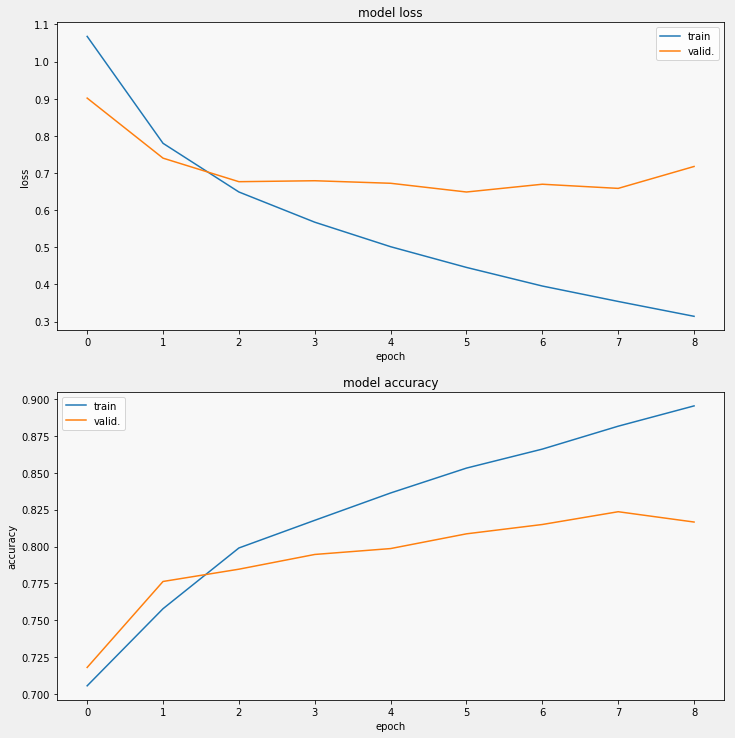

In [45]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 212)

In [46]:
test_generator = test_datagen.flow_from_dataframe(
                    dataframe=x_test,
                    directory="../output/kaggle/working/train_images/",
                    x_col="file_name",
                    y_col="classes_wild",
                    batch_size=32,
                    seed=424,
                    shuffle=True,
                    class_mode="categorical",
                    target_size=(32, 32))

Found 3000 images belonging to 14 classes.


In [48]:
test_loss, test_acc =model.evaluate_generator(test_generator, steps=32)
print('test_loss: {} and test_acc: {} '.format(test_loss, test_acc))

test_loss: 0.6878410671302613 and test_acc: 0.8096666932106018 
